In [1]:
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
from tqdm import tqdm

import matplotlib.pyplot as plt

Hasta ahora, lo único que se hizo fue quedarse con los reviews más relevantes sin considerar el contenido escrito. Es decir, se consideró la categoría, el largo, la valorización y cosas por el estilo, pero no lo que dicen explícitamente. Ahora, el objetivo sería descartar los que son cualquier cosa, los que están en otro idioma, los que dicen ser de una puntuación pero ponen otra, etc. 

In [2]:
# df = pd.read_csv('./reviews_all_parts_sampled_by_cat_and_limited_by_prods_09-01-2021.csv')

# df_esp = df[df['country']!='MLB']
# print(df_esp['review_rate'].value_counts())
# df_por = df[df['country']=='MLB']
# print(df_por['review_rate'].value_counts())

# df_esp.to_csv('./reviews_esp_full.csv',index=False)
# df_por.to_csv('./reviews_por_full.csv',index=False)

5    97525
4    97525
3    97525
2    97525
1    97525
Name: review_rate, dtype: int64
5    54863
4    54863
3    54863
2    54863
1    54863
Name: review_rate, dtype: int64


In [2]:
df_esp = pd.read_csv('./reviews_esp_full.csv')
#df_por = pd.read_csv('./reviews_por_full.csv')

Bueno, la lógica va a ser que todos los characters que tengan frecuencia mayor a 150 se van a poder aprender del contexto, por lo que vamos a corregir nada más que los que tengan una frecuencia menor. 

In [3]:
ds_text = df_esp['review_title'] + ' ' + df_esp['review_content']
chars_vocab = dict(Counter(ds_text.str.cat(sep='')))
idx = np.argsort(list(chars_vocab.values()))[::-1]
chars_vocab = {list(chars_vocab.keys())[i]:list(chars_vocab.values())[i] for i in idx}
rare_chars = ''.join([char for char,count in chars_vocab.items() if count <=150])[::-1]
rare_chars
# non_ascii = 'áàâãäÁÀÂÃÄéèêëÉÈÊẼËíìîĩïÍÌÎĨÏóòôõöÓÒÔÕÖúùûũüÚÙÛŨÜñÑ'
# rare_chars =  ''.join(sorted(list(set(rare_chars) - set(non_ascii) - set(string.ascii_letters) - set(list(string.punctuation)) - {'¡', '¿'})))
# rare_chars

'¾õÄ¤„ÖÏØÀ‰Ò\x08Ýšæ�¥³µÌÇ‹›ýâ£Ù¢¼È¹÷î±þ™ßûã®ï€ôÜøë¬ð>ö‘åä<ê²½—ç–·«ª\\»}×|’~{`^•]¨[…'

In [19]:
for char in rare_chars:
    ds_rare_comments = ds_text[ds_text.str.contains(r'[{}]+'.format(re.escape(char)))]
    print('Char {}. len: {}'.format(char,len(ds_rare_comments)))
    for i, comment in ds_rare_comments.items():
        print(i, comment, df_esp.loc[i,['review_rate']].squeeze())
        print() 

Char ¾. len: 1
447832 excelente relación calidad precio Excelente relación calidad precio, mercadolibre me pide que escriba mas entonces les dejo una receta de buñuelos: ingredientes. Aceite vegetal para freír. ¾ de taza de fécula de maíz. 1/4 de taza de harina de yuca. 1 taza de queso costeño o feta rallado. 1/2 taza de queso fresco. 2 huevos. 1/4 de cucharadita de polvo de hornear. 2 cucharadas de azúcar. Una pizca de sal. 1 cucharada de leche. . Preparación. Coloque todos los ingredientes, excepto el aceite en un tazón mediano y mezcle bien con las manos hasta obtener una masa suave y formar bolitas. . . En una olla muy profunda, caliente el aceite vegetal a 300 ° f. Colocar con cuidado las bolas en el aceite caliente. Cubra la olla y después de unos 3 a 4 minutos, suba la temperatura y freír hasta que estén doradas. Buñuelos colombianos. . Retirar del aceite y escurrir en un plato cubierto con toallas de papel. Servir. . Espero los disfruten gracias. 5

Char õ. len: 1
428380 Lo rec

In [3]:
def replace_in_df(df,i,old,new):
    df.loc[i,['review_content']] = df.loc[i,['review_content']].str.replace(old,new,regex=True)
    df.loc[i,['review_title']] = df.loc[i,['review_title']].str.replace(old,new,regex=True)
    return df

to_be_removed = [464553,363644,347504,269975,478983,44628,347897,38514,157242,40074,37739,478983,303317,441366,259490,313158,484801,485534,347897,457425,478983,478983,166970,259490,313158,455157,125905,259490,481068,484801,356394,117652,235825,420450,420708,476574,117652,235825,420450,420708,476574,164373,457425,13306,13306,301898,132356,147212,160625,166970,167865,350100,81051,271387,287372,384171,158373,481068,470861] 

to_be_replaced = [(447832,'¾','3/4'),
(428380,'õ','ó'),
(419384,'Ä','A'),
(406126,'m¤ 2','m²'),
(383905,'„','"'),
(367252,'Ö','Ó'),
(355800,'Ø',''),
(210144,'À','Á'),
(76618,'Ò','Ó'),
(216813,'\x08',''),
(112157,'š','s'),
(155101,'�',''),
(223781,'�',''),
(228727,'¥','y '),
(118224,r'(10\?, 10\? y 10¹²)','(10^6, 10^9 y 10^12)'),
(118224,r'(2²\?, 2³\? y 2\?\?)','(2^6, 2^9 y 2^12)'),
(191723,'Ì','I'),
(412618,'Ì','I'),
(22084,'Ç',''),
(349750,'Ç','C'),
(239611,r'‹\?john\?›',''),
(240804,r'‹\?john\?›',''),
(283360,'ý','y'),
(374532,'ý','y'),
(204459,'â','á'),
(446460,'â','á'),
(476046,'â','á'),
(55791,'Ù','Ú'),
(109573,'Ù','Ú'),
(404634,'Ù','Ú'),
(299512,'¢','c'),
(77763,'¼','1/4'),
(428655,'¼','1/4'),
(163140,'È','É'),
(282870,'È','É'),
(305295,'È','É'),
(309364,'È','É'),
(34719,'¹','p'),
(147063,'÷','%'),
(120172,'÷ -',''),
(110054,'î','í'),
(317213,'î','í'),
(364279,'î','í'),
(430000,'î','í'),
(129519,'±',''),
(259644,'™',' '),
(118905,'™',''),
(404164,'™',''),
(440504,'™',''),
(8758,'ß','s'),
(299512,'ß','b'),
(80699,'û','ú'),
(139564,'û','ú'),
(140969,'û','ú'),
(99645,'û','ú'),
(282352,'û','ú'),
(466707,'®',''),
(437981,'®',''),
(404164,'®',''),
(355258,'®',''),
(304123,'®',''),
(259659,'®',''),
(231414,'®',''),
(128218,'®',''),
(849,'ï','í'),
(130774,'ï','í'),
(138481,'ï','í'),
(177357,'ï','i'),
(197283,'ï','í'),
(199641,'ï','í'),
(213864,'ï','í'),
(280878,'ï','i'),
(387460,'ï','i'),
(6258,'€','e'),
(11712,'v€nded0r','vendedor'),
(110054,'ô','ó'),
(140969,'ô','ó'),
(224260,'ô','ó'),
(230294,'ô','ó'),
(260602,'ô','ó'),
(321394,'ô','o'),
(330893,'ô','ó'),
(364279,'ô','ó'),
(60578,'Ü','Ú'),
(236433,'Ü','Ú'),
(250532,'Ü','Ú'),
(378296,'Ü','Ú'),
(400473,'Ü','Ú'),
(307173,'ø','o'),
(314320,'ø','ó'),
(352424,'ø','ó'),
(440768,'ø','ó'),
(449334,'ø','o'),
(4917,'ë','é'),
(60391,'ë','e'),
(182836,'ë','é'),
(277459,'ë','é'),
(305356,'ë','é'),
(322401,'ë','é'),
(388675,'ë','é'),
(417075,'ë','é'),
(482290,'ë','é'),
(1635,'cödico','código'),
(42130,'ö','ó'),
(89221,'ö','ó'),
(123846,'ö','ó'),
(204178,'ö','ó'),
(217784,'ö','ó'),
(233157,'ö','ó'),
(285862,'ö','ó'),
(11857,'‘','"'),
(21861,'‘','"'),
(32049,'‘',''),
(104545,'‘',''),
(117699,'‘','"'),
(149344,'‘','"'),
(160748,'‘','"'),
(250773,'‘','"'),
(420470,'‘','"'),
(421574,'‘','"'),
(454108,'‘','"'),
(56812,'å','á'),
(203863,'å','á'),
(228686,'å','á'),
(248888,'å','á'),
(249631,'å','á'),
(269195,'å','á'),
(322076,'å','á'),
(329255,'å','á'),
(372725,'å','á'),
(384474,'å','á'),
(392538,'å','á'),
(427048,'å','a'),
(431410,'å','á'),
(261544,'ä','á'),
(392816,'präcto','práctico'),
(439059,'ä','a'),
(446949,'ä','á'),
(86973,'ê','e'),
(123637,'ê','é'),
(206331,'ê','e'),
(210144,'ê','é'),
(223524,'ê','é'),
(319983,'ê','é'),
(326554,'ê','é'),
(403951,'ê','e'),
(454491,'ê','é'),
(482286,'ê','é'),
(29924,'½','1/2'),
(93290,'½','1/2'),
(101489,'½','1/2'),
(117670,'½','1/2'),
(117712,'½','1/2'),
(117781,'½','1/2'),
(121558,'½','1/2'),
(242904,'½','1/2'),
(270866,'½','1/2'),
(321027,'½','1/2'),
(323702,'½','1/2'),
(344399,'½','1/2'),
(370561,'½','1/2'),
(374855,'½','1/2'),
(375928,'½','1/2'),
(387237,'½','1/2'),
(442487,'½','1/2'),
(443316,'½','1/2'),
(476555,'½','1/2'),
(59435,'—','-'),
(80912,'—','-'),
(89208,'—','-'),
(129898,'—','-'),
(160858,'—','-'),
(206771,'—','-'),
(242714,'—','-'),
(348601,'—','-'),
(356430,'—','-'),
(362720,'—','-'),
(368248,'—','-'),
(405254,'—','-'),
(453809,'—','-'),
(3207,'ç',''),
(6550,'ç',''),
(30779,'ç',''),
(58400,'ç','c'),
(66515,'ç','c'),
(68235,'ç',''),
(79860,'ç',''),
(117506,'ç',''),
(176416,'ç','c'),
(176710,'ç',''),
(290061,'ç','c'),
(305699,'ç','c'),
(320855,'ç','c'),
(326332,'ç','c'),
(350035,'ç','c'),
(388304,'ç','c'),
(419504,'ç',''),
(424920,'ç','c'),
(33939,'–','-'),
(62326,'–','-'),
(88917,'–','-'),
(117686,'–','-'),
(117699,'–','-'),
(128955,'–','-'),
(128986,'–','-'),
(231978,'–','-'),
(262964,'–','-'),
(403834,'–','-'),
(416359,'–','-'),
(420453,'–','-'),
(420470,'–','-'),
(432963,'·','•'),
(429047,'·','•'),
(408666,'·','•'),
(403814,'·','•'),
(288154,'·','•'),
(280631,'·','•'),
(260614,'·','•'),
(242937,'·','•'),
(146076,'·','•'),
(110516,'·','•'),
(80830,'·','•'),
(51929,'·','•'),
(57804,'ª','á'),
(168288,'ª','°'),
(231578,'ª','°'),
(271139,'ª','a'),
(357510,'ª','°'),
(370879,'ª','°'),
(394658,'ª','º'),
(416448,'ª','°'),
(423179,'ª','°'),
(424580,'ª','°'),
(453493,'ª','°'),
(106575,'¨','y '),
(121561,'¨',''),
(88509,'¨',' '),
(186889,'¨',''),
(188549,'¨',''),
(205930,'¨',''),
(231323,'¨',''),
(239640,'¨',''),
(354652,'¨',''),
(365688,'¨',''),
(400567,'¨',''),
(414157,'¨',''),
(59527,r'[¨]+','"'),
(340999,r'[¨]+','"'),
(69519,r'[¨]+','"'),
(178192,r'[¨]+','"'),
(205840,r'[¨]+','"'),
(324111,r'[¨]+','"'),
(456602,r'[¨]+','"'),
(11292,r'[¨]+','"'),
(79405,r'[¨]+','"'),
(40878,r'[¨]+','"'),
(420912,r'[¨]+','"'),
(142387,r'[¨]+','"'),
(70458,r'[¨]+','"'),
(472123,r'[¨]+','"'),
(421311,r'[¨]+','"'),
(255299,r'[¨]+','"'),
(11462,r'[¨]+','"'),
(346054,r'[¨]+','"'),
(448586,r'[¨]+','"'),
(29650,r'[¨]+','"'),
(123092,r'[¨]+','"'),
(422742,r'[¨]+','"'),
(71000,r'[¨]+','"'),
(420696,r'[¨]+','"'),
(94171,r'[¨]+','"'),
(131804,r'[¨]+','"'),
(59099,r'[¨]+','"'),
(289919,r'[¨]+','"'),
(207712,r'[¨]+','"'),
(421728,r'[¨]+','"'),
(433126,r'[¨]+','"'),
(3822,r'[¨]+','"'),
(485619,r'[¨]+','"'),
(242806,r'[¨]+','"'),
(393081,r'[¨]+','"'),
(446334,r'[¨]+','"'),
(130047,r'[¨]+','"'),
(80830,r'[«»]+','"'),
(88592,r'[«»]+','"'),
(100886,r'[«»]+','"'),
(117652,r'[«»]+','"'),
(117905,r'[«»]+','"'),
(120529,r'[«»]+','"'),
(123936,r'[«»]+','"'),
(128880,r'[«»]+','"'),
(139708,r'[«»]+','"'),
(153431,r'[«»]+','"'),
(154385,r'[«»]+','"'),
(177663,r'[«»]+','"'),
(212273,r'[«»]+','"'),
(224144,r'[«»]+','"'),
(231110,r'[«»]+','"'),
(232647,r'[«»]+','"'),
(235825,r'[«»]+','"'),
(241086,r'[«»]+','"'),
(304216,r'[«»]+','"'),
(420450,r'[«»]+','"'),
(420708,r'[«»]+','"'),
(476574,r'[«»]+','"'),
(476722,r'[«»]+','"'),
(4262,r'[×]+','x'),
(13306,r'[×]+','x'),
(17192,r'[×]+','x'),
(32174,r'[×]+','x'),
(34269,r'[×]+','x'),
(68046,r'[×]+','x'),
(123941,r'[×]+','x'),
(128849,r'[×]+','x'),
(138260,r'[×]+','x'),
(138705,r'[×]+','x'),
(152250,r'[×]+','x'),
(189048,r'[×]+','x'),
(190493,r'[×]+','x'),
(212161,r'[×]+','x'),
(288305,r'[×]+','x'),
(293154,r'[×]+','x'),
(301898,r'[×]+','x'),
(304153,r'[×]+','x'),
(317381,r'[×]+','x'),
(326339,r'[×]+','x'),
(326754,r'[×]+','x'),
(360737,r'[×]+','x'),
(371615,r'[×]+','x'),
(388070,r'[×]+','x'),
(414520,r'[×]+','x'),
(420734,r'[×]+','x'),
(424092,r'[×]+','x'),
(428459,r'[×]+','x'),
(434722,r'[×]+','x'),
(465393,r'[×]+','x'),
(465823,r'[×]+','x'),
(11204,r'[…]+','...'),
(19708,r'[…]+','...'),
(22013,r'[…]+','...'),
(33890,r'[…]+','...'),
(34626,r'[…]+','...'),
(49371,r'[…]+','...'),
(57661,r'[…]+','...'),
(59631,r'[…]+','...'),
(67028,r'[…]+','...'),
(91053,r'[…]+','...'),
(95249,r'[…]+','...'),
(100800,r'[…]+','...'),
(105302,r'[…]+','...'),
(110302,r'[…]+','...'),
(117682,r'[…]+','...'),
(119856,r'[…]+','...'),
(123725,r'[…]+','...'),
(124347,r'[…]+','...'),
(128074,r'[…]+','...'),
(132048,r'[…]+','...'),
(132356,r'[…]+','...'),
(134484,r'[…]+','...'),
(141604,r'[…]+','...'),
(142639,r'[…]+','...'),
(153381,r'[…]+','...'),
(172945,r'[…]+','...'),
(188968,r'[…]+','...'),
(207278,r'[…]+','...'),
(208325,r'[…]+','...'),
(215815,r'[…]+','...'),
(217512,r'[…]+','...'),
(230004,r'[…]+','...'),
(232068,r'[…]+','...'),
(244959,r'[…]+','...'),
(256894,r'[…]+','...'),
(259457,r'[…]+','...'),
(259463,r'[…]+','...'),
(262054,r'[…]+','...'),
(265127,r'[…]+','...'),
(272373,r'[…]+','...'),
(286511,r'[…]+','...'),
(287759,r'[…]+','...'),
(288380,r'[…]+','...'),
(297761,r'[…]+','...'),
(305113,r'[…]+','...'),
(322492,r'[…]+','...'),
(331509,r'[…]+','...'),
(337554,r'[…]+','...'),
(347439,r'[…]+','...'),
(348112,r'[…]+','...'),
(354167,r'[…]+','...'),
(367168,r'[…]+','...'),
(393290,r'[…]+','...'),
(404188,r'[…]+','...'),
(410520,r'[…]+','...'),
(420489,r'[…]+','...'),
(420502,r'[…]+','...'),
(432274,r'[…]+','...'),
(437305,r'[…]+','...'),
(437775,r'[…]+','...'),
(439173,r'[…]+','...'),
(442969,r'[…]+','...'),
(460107,r'[…]+','...'),
(463015,r'[…]+','...'),
(464659,r'[…]+','...'),
(477934,r'[…]+','...'),
(479329,r'[…]+','...'),
(479708,r'[…]+','...'),
(481003,r'[…]+','...'),
(482570,r'[…]+','...'),
(483795,r'[…]+','...'),
(487428,r'[…]+','...'),
(487495,r'[…]+','...'),
(11813,r'[’]+',"'"),
(11857,r'[’]+',"'"),
(21861,r'[’]+',"'"),
(35303,r'[’]+',"'"),
(39455,r'[’]+',"'"),
(41014,r'[’]+',"'"),
(45943,r'[’]+',"'"),
(57782,r'[’]+',"'"),
(65337,r'[’]+',"'"),
(67299,r'[’]+',"'"),
(79414,r'[’]+',"'"),
(81266,r'[’]+',"'"),
(86428,r'[’]+',"'"),
(92043,r'[’]+',"'"),
(92744,r'[’]+',"'"),
(117699,r'[’]+',"'"),
(120589,r'[’]+',"'"),
(126392,r'[’]+',"'"),
(128849,r'[’]+',"'"),
(131129,r'[’]+',"'"),
(132356,r'[’]+',"'"),
(135252,r'[’]+',"'"),
(147165,r'[’]+',"'"),
(147212,r'[’]+',"'"),
(159105,r'[’]+',"'"),
(160625,r'[’]+',"'"),
(160748,r'[’]+',"'"),
(163857,r'[’]+',"'"),
(166970,r'[’]+',"'"),
(167865,r'[’]+',"'"),
(183949,r'[’]+',"'"),
(200780,r'[’]+',"'"),
(250773,r'[’]+',"'"),
(265774,r'[’]+',"'"),
(271198,r'[’]+',"'"),
(305534,r'[’]+',"'"),
(313071,r'[’]+',"'"),
(348358,r'[’]+',"'"),
(350100,r'[’]+',"'"),
(372776,r'[’]+',"'"),
(378279,r'[’]+',"'"),
(381466,r'[’]+',"'"),
(398151,r'[’]+',"'"),
(400513,r'[’]+',"'"),
(420470,r'[’]+',"'"),
(421574,r'[’]+',"'"),
(431379,r'[’]+',"'"),
(444006,r'[’]+',"'"),
(454108,r'[’]+',"'"),
(479629,r'[’]+',"'"),
(486263,r'[’]+',"'"),
(486370,r'[’]+',"'"),
(487023,r'[’]+',"'")]

In [4]:
to_be_replaced = list(set(to_be_replaced))
for i,old,new in tqdm(to_be_replaced):
    df_esp = replace_in_df(df_esp,i,old,new)

to_be_removed = list(set(to_be_removed))
df_esp = df_esp.drop(to_be_removed)

100%|██████████| 463/463 [00:33<00:00, 13.65it/s]


In [5]:
ds_text = df_esp['review_title'] + ' ' + df_esp['review_content']
chars_vocab = dict(Counter(ds_text.str.cat(sep='')))
idx = np.argsort(list(chars_vocab.values()))[::-1]
chars_vocab = {list(chars_vocab.keys())[i]:list(chars_vocab.values())[i] for i in idx}
rare_chars = ''.join([char for char,count in chars_vocab.items() if count <=150])[::-1]
print(rare_chars)
chars_vocab

û÷³ëö€µ±øÜä¬><²ª}\{|`]~[^•


{' ': 17799932,
 'e': 10516704,
 'a': 9242708,
 'o': 7614085,
 'n': 5395138,
 's': 5080373,
 'r': 5006424,
 'l': 4584740,
 'i': 4202937,
 'u': 3893138,
 'c': 3741395,
 'd': 3482390,
 't': 3374358,
 'm': 2622711,
 'p': 2607598,
 'b': 1237786,
 '.': 1206596,
 'y': 1098734,
 ',': 896483,
 'q': 875538,
 'g': 773679,
 'v': 640715,
 'f': 619554,
 'h': 510286,
 'j': 324399,
 'ó': 319453,
 'E': 318285,
 'á': 287449,
 'M': 267035,
 'í': 231480,
 'x': 191019,
 'z': 178546,
 'L': 170656,
 'N': 154610,
 '!': 142004,
 'é': 139715,
 'B': 128004,
 'P': 119028,
 'ñ': 110129,
 'S': 107090,
 '0': 88752,
 'C': 78385,
 'A': 75696,
 'ú': 68514,
 '1': 60642,
 'R': 54796,
 'T': 54061,
 'D': 49887,
 '2': 46150,
 ')': 38325,
 '(': 38155,
 'U': 34593,
 '5': 33888,
 'k': 33753,
 'O': 33384,
 '3': 32125,
 'I': 27655,
 'F': 26959,
 'Y': 25976,
 '4': 24310,
 'H': 24087,
 '-': 23938,
 '"': 20659,
 'w': 17666,
 ':': 14956,
 '?': 14730,
 '/': 14386,
 'V': 13562,
 '6': 12817,
 '%': 12478,
 'G': 11990,
 '8': 11588,
 '7'

MLA
MLM
MLU
MCO
MLC
MLV
MPE


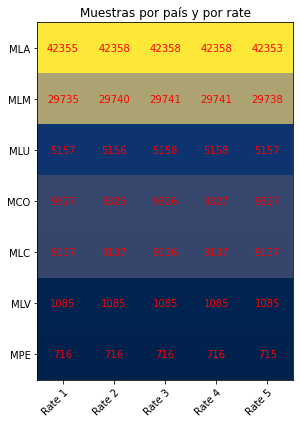

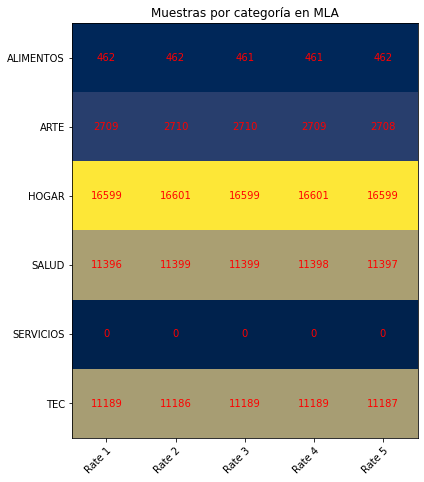

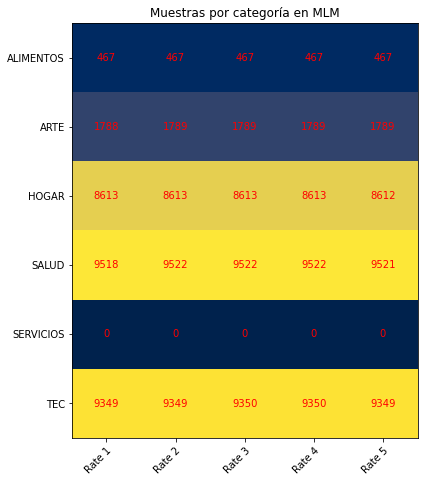

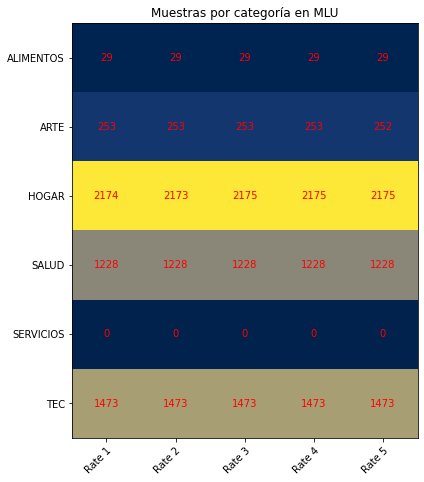

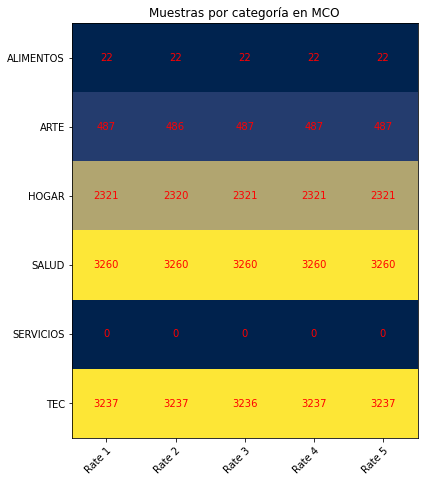

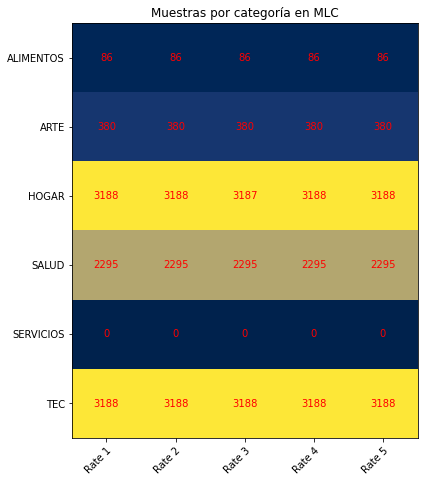

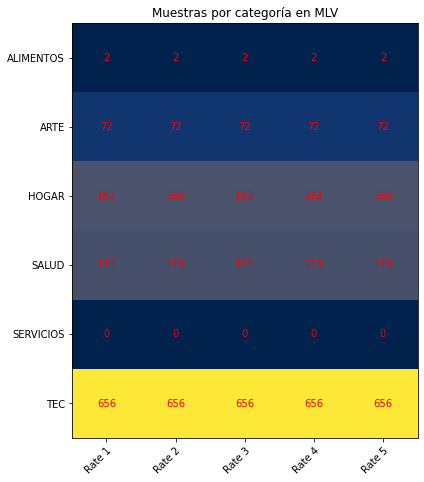

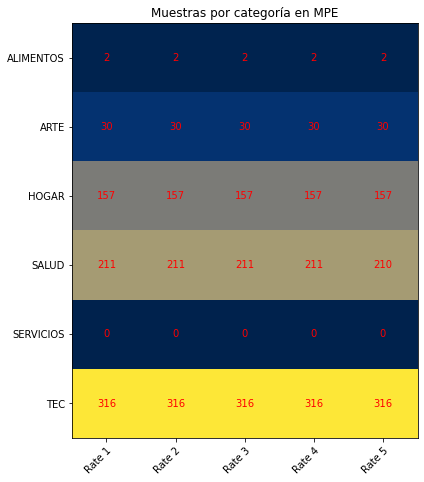

In [5]:
def plot_heatmap(matrix,countries,rates):

    fig, ax = plt.subplots(1,1,figsize=(len(countries),len(rates)+1))
    im = ax.imshow(matrix,cmap='cividis')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(rates)))
    ax.set_yticks(np.arange(len(countries)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(['Rate {}'.format(s) for s in rates])
    ax.set_yticklabels(countries)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(countries)):
        for j in range(len(rates)):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="red")

    ax.set_title("Muestras por país y por rate")
    fig.tight_layout()
    return fig, ax

df = df_esp
countries = ['MLA','MLM','MLU','MCO','MLC','MLV','MPE']
rates = [1, 2, 3, 4, 5]
matrix = np.zeros((len(countries),len(rates)),dtype=np.int)
for i,country in enumerate(countries):
    for j,rate in enumerate(rates):
        mymask = (df['review_rate'] == rate) & (df['country'] == country)
        matrix[i,j] = len(df[mymask])

fig, ax = plot_heatmap(matrix,countries,rates)
fig.show()


def plot_heatmap2(matrix,yticks,xticks,title):

    fig, ax = plt.subplots(1,1,figsize=(len(yticks),len(xticks)*2))
    im = ax.imshow(matrix,cmap='cividis')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(xticks)))
    ax.set_yticks(np.arange(len(yticks)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(['Rate {}'.format(s) for s in xticks])
    ax.set_yticklabels(yticks)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(yticks)):
        for j in range(len(xticks)):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="red")

    ax.set_title(title)
    fig.tight_layout()
    return fig, ax

abbreviations = {'Hogar / Casa': 'HOGAR',
'Tecnología y electrónica / Tecnologia e electronica': 'TEC',
'Arte y entretenimiento / Arte e Entretenimiento': 'ARTE',
'Salud, ropa y cuidado personal / Saúde, roupas e cuidado pessoal': 'SALUD',
'Alimentos y Bebidas / Alimentos e Bebidas': 'ALIMENTOS',
'Servicios / Serviços': 'SERVICIOS'}

categories = sorted(list(abbreviations.keys()))
abbs = [abbreviations[cat] for cat in categories]

for country in countries:
    print(country)
    matrix = np.zeros((len(categories),len(rates)),dtype=np.int)
    for i,category in enumerate(categories):
        for j,rate in enumerate(rates):
            mymask = (df['review_rate'] == rate) & (df['category'] == category) & (df['country'] == country)
            matrix[i,j] = mymask.sum()

    fig, ax = plot_heatmap2(matrix,abbs,rates,title='Muestras por categoría en {}'.format(country))
    fig.show()

In [7]:
df_esp.to_csv('./reviews_esp_cleaned_chars_11-01-2021.csv',index=False)

Ahora con portugués. La única diferencia es que vamos a tratar de eliminar los comentarios en lugar de modificarlos.

In [2]:
df_por = pd.read_csv('./reviews_por_full.csv')

In [4]:
ds_text = df_por['review_title'] + ' ' + df_por['review_content']
chars_vocab = dict(Counter(ds_text.str.cat(sep='')))
idx = np.argsort(list(chars_vocab.values()))[::-1]
chars_vocab = {list(chars_vocab.keys())[i]:list(chars_vocab.values())[i] for i in idx}
rare_chars = ''.join([char for char,count in chars_vocab.items() if count <=100])[::-1]
rare_chars

'Üœý«¿½£¥·\x08Ø¹©ß˜îïÖ�ùÙæ¾¬÷³ˆ‚øË¯¡±‘®ö{ìåë}—…–>ÔÕ¨|äÂ•<üÊ’Ò×`[]²^~YÈò'

In [5]:
df_por = df_por[~ds_text.str.contains('|'.join([re.escape(char) for char in chars_vocab.keys() if chars_vocab[char] < 100]))]

MLB


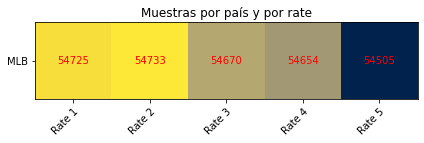

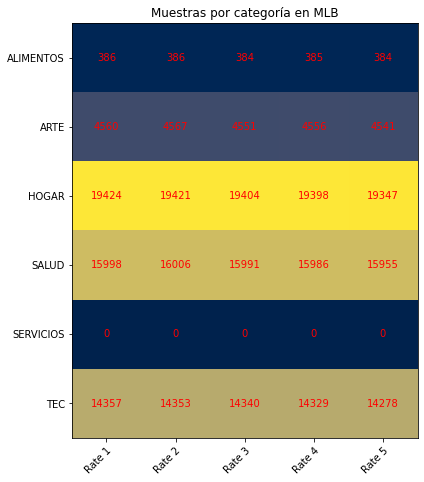

In [6]:
def plot_heatmap(matrix,countries,rates):

    fig, ax = plt.subplots(1,1,figsize=(6,10))
    im = ax.imshow(matrix,cmap='cividis')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(rates)))
    ax.set_yticks(np.arange(len(countries)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(['Rate {}'.format(s) for s in rates])
    ax.set_yticklabels(countries)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(countries)):
        for j in range(len(rates)):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="red")

    ax.set_title("Muestras por país y por rate")
    fig.tight_layout()
    return fig, ax

df = df_por
countries = ['MLB']
rates = [1, 2, 3, 4, 5]
matrix = np.zeros((len(countries),len(rates)),dtype=np.int)
for i,country in enumerate(countries):
    for j,rate in enumerate(rates):
        mymask = (df['review_rate'] == rate) & (df['country'] == country)
        matrix[i,j] = len(df[mymask])

fig, ax = plot_heatmap(matrix,countries,rates)
fig.show()


def plot_heatmap2(matrix,yticks,xticks,title):

    fig, ax = plt.subplots(1,1,figsize=(len(yticks),len(xticks)*2))
    im = ax.imshow(matrix,cmap='cividis')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(xticks)))
    ax.set_yticks(np.arange(len(yticks)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(['Rate {}'.format(s) for s in xticks])
    ax.set_yticklabels(yticks)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(yticks)):
        for j in range(len(xticks)):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="red")

    ax.set_title(title)
    fig.tight_layout()
    return fig, ax

abbreviations = {'Hogar / Casa': 'HOGAR',
'Tecnología y electrónica / Tecnologia e electronica': 'TEC',
'Arte y entretenimiento / Arte e Entretenimiento': 'ARTE',
'Salud, ropa y cuidado personal / Saúde, roupas e cuidado pessoal': 'SALUD',
'Alimentos y Bebidas / Alimentos e Bebidas': 'ALIMENTOS',
'Servicios / Serviços': 'SERVICIOS'}

categories = sorted(list(abbreviations.keys()))
abbs = [abbreviations[cat] for cat in categories]

for country in countries:
    print(country)
    matrix = np.zeros((len(categories),len(rates)),dtype=np.int)
    for i,category in enumerate(categories):
        for j,rate in enumerate(rates):
            mymask = (df['review_rate'] == rate) & (df['category'] == category) & (df['country'] == country)
            matrix[i,j] = mymask.sum()

    fig, ax = plot_heatmap2(matrix,abbs,rates,title='Muestras por categoría en {}'.format(country))
    fig.show()

In [7]:
df_por.to_csv('./reviews_por_cleaned_chars_11-01-2021.csv',index=False)

# Datasets limpiados (un poco)

In [5]:
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
df_esp = pd.read_csv('./reviews_esp_cleaned_chars_11-01-2021.csv')
df_por = pd.read_csv('./reviews_por_cleaned_chars_11-01-2021.csv')

In [ ]:
# NO DESCOMENTAR. TARDA MUCHO. SE CORRE EN MAFALDA
# !python lang_detect_v2.py

In [3]:
df_all = pd.concat([df_esp,df_por],ignore_index=True) 
mask_spacy_es = pd.read_csv('./mask_spacy_es.csv').squeeze()
mask_spacy_pt = pd.read_csv('./mask_spacy_pt.csv').squeeze()
mask_langdetect = pd.read_csv('./mask_langdetect.csv').squeeze()
mask_langid = pd.read_csv('./mask_langid.csv').squeeze()
mask_fasttext = pd.read_csv('./mask_fasttext.csv').squeeze()
# mask = mask_fasttext & mask_langid & mask_spacy_es & mask_spacy_pt & mask_langdetect 
# df = df_all[mask]
df_all['mask_score'] = mask_spacy_es.astype(int) + mask_spacy_pt.astype(int) + mask_langdetect.astype(int) + mask_langid.astype(int) + mask_fasttext.astype(int)
df_esp_new = df_all[df_all['country'] != 'MLB'].sort_values(by=['mask_score'],ascending=False)
df_por_new = df_all[df_all['country'] == 'MLB'].sort_values(by=['mask_score'],ascending=False)

In [6]:
for i, comment in df_esp_new['review_content'][df_esp_new['mask_score'] < 3].items():
    print(i, comment)

163133 No sirve para nada , gastas dinero sin resultados, para ,los que vean esta reseña, no sirve nada, no la compren.
301647 No sirve para nada. El iman se despega. No sirve.
140417 Bueno bueno bueno bueno bueno bueno bueno bueno buenobuenobuenobuenobuenobueno bueno bueno bueno bueno bueno bueno bueno bueno buenobueno buenobueno bueno buenobuenobuenobuenobuenobuenobuenobuenobuenobuenovvvbuenobuenovvbuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobuenobueno.
331604 Todavía no lo probé se ve medio frágil cuando lo pruebe le aviso.
186329 Color normal,materiales normal.
331603 Muy mala calidad no dura ni dos horas no la recomiendo para nada.
316797 El prroducto no sirve, es incomodo y no se puede usar como corrector.
463552 Bonito pero no tiene buen sonido.
191915 Son sillas para niños. Yo soy norteño y requiero king size. No me gustaron.
199652 No me gustó no cumple con la. Norma no es

In [4]:
to_be_removed = [140417,127632,204320,215938,335119,443596,267428,437060,437032,67020,265651,345318,226853,454682,49929,383459,113429,270193,464014,464017,482137,139461,347418,468428,93602,348072,120607,51193,303268,303135,200077,169049,51401,157771,347971,197021,42462,302093,117681,427438,379868,379868,50863,195333,432818,334729,413443,164063,49033,447078,338028,129382,338394,76326,487365,351006,129226,116861,456259,405814,49136,209233,455914,486997,487139,453965,130184,337874,128841,300062,49239,259440,48970,468791,128629,139646,259446,300145,487059,28710,386961,193780,486516,481088,333864,40119,280304,40035,443912,222724,333913,280485,462051,13402,438611,419060,396946,444218,39957,123754,477522,286084,187563,443132,196890,196903,196893,477896,40353,187821,112222,420458,40543,40532,40533,438549,345902,54283,398150,366598,38844,54087,445624,479973,54235,141181,428443,39465,97112,195998,133701,39615,444319,461515,428134,64627,345679,54618,461009,196001,96979,345516,345533,279303,54004,464520,184994,463640,464494,440850,11191,252438,242715,11193,184975,334836,88208,394184,88337,225072,268171,186421,186459,12024,383848,58488,186132,185503,185546,270045,283171,185814,270149,475043,463906,87473,334483,442314,9768,225541,225544,476718,421869,421307,196983,464936,142404,12990,196956,357929,87115,439252,199832,334423,421344,442010,244079,463289,22620,215065,184483,269302,184392,61107,197140,197133,214835,281364,284623,183953,138606,51030,104093,484071,50994,236636,138641,262973,236387,302123,157504,138288,411051,71859,325545,19211,117878,483767,410705,483852,169129,256565,51268,127006,247179,403547,49756,130433,364968,485979,130591,456842,301201,74606,260452,128004,232035,275308,486188,156892,156891,49586,328810,259575,374456,259508,156467,453462,453511,145149,49643,352898,301750,484985,173099,231244,115802,301923,338895,139032,130727,139064,105505,261150,375912,449043,445779,53100,446833,379881,140989,481266,304964,202555,265574,19953,195405,195224,481643,93344,202912,336776,430824,15008,69565,459319,305047,314573,25147,125102,195666,189699,166524,380278,314485,472111,125016,166944,446301,250628,446433,278463,245934,304068,347757,347741,80501,336956,347599,118466,293980,412028,125895,230098,80265,378559,47166,80290,138216,459090,203162,221180,158437,81347,303969,347476,36218,336928,229423,437028,303695,437004,303658,132010,482152,150588,303619]

df_esp_new = df_esp_new.drop(to_be_removed)

MLA
MLM
MLU
MCO
MLC
MLV
MPE


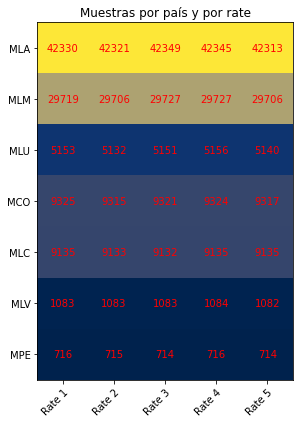

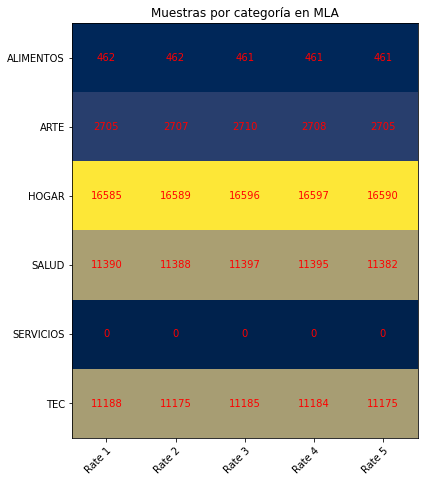

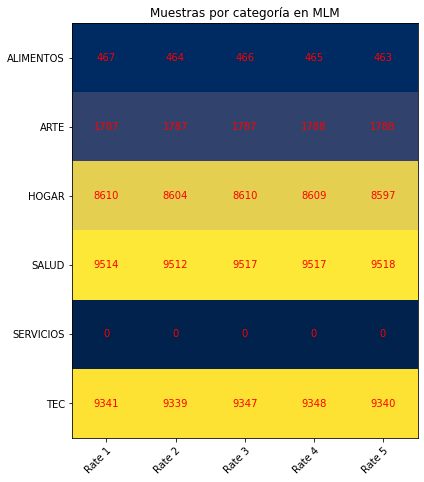

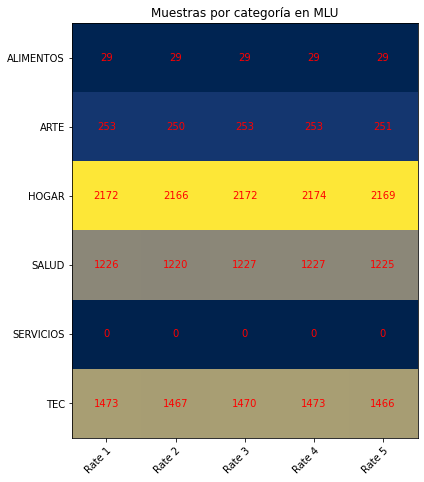

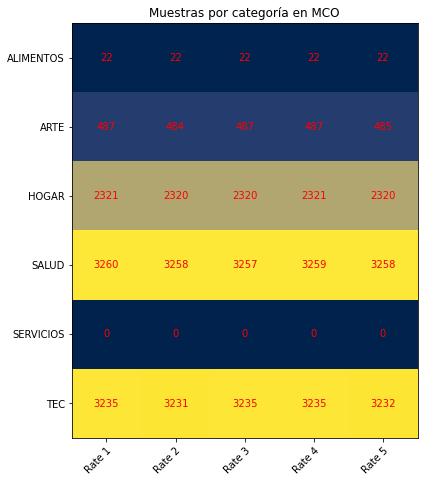

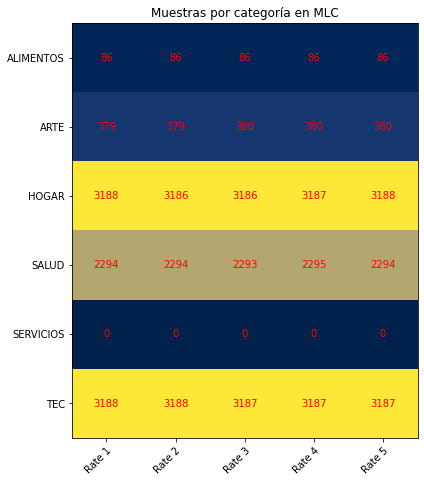

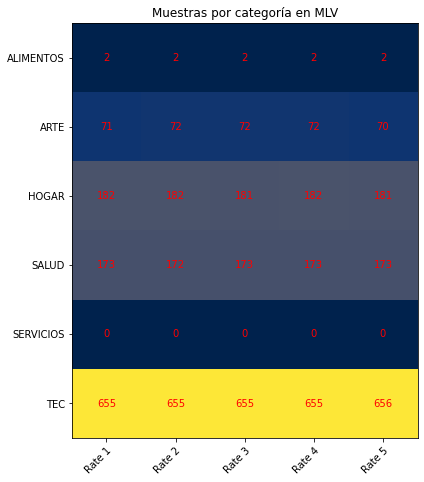

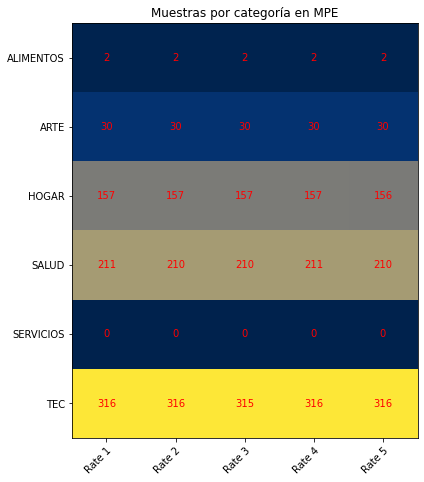

In [6]:
def plot_heatmap(matrix,countries,rates):

    fig, ax = plt.subplots(1,1,figsize=(len(countries),len(rates)+1))
    im = ax.imshow(matrix,cmap='cividis')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(rates)))
    ax.set_yticks(np.arange(len(countries)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(['Rate {}'.format(s) for s in rates])
    ax.set_yticklabels(countries)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(countries)):
        for j in range(len(rates)):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="red")

    ax.set_title("Muestras por país y por rate")
    fig.tight_layout()
    return fig, ax

df = df_esp_new
countries = ['MLA','MLM','MLU','MCO','MLC','MLV','MPE']
rates = [1, 2, 3, 4, 5]
matrix = np.zeros((len(countries),len(rates)),dtype=np.int)
for i,country in enumerate(countries):
    for j,rate in enumerate(rates):
        mymask = (df['review_rate'] == rate) & (df['country'] == country)
        matrix[i,j] = len(df[mymask])

fig, ax = plot_heatmap(matrix,countries,rates)
fig.show()


def plot_heatmap2(matrix,yticks,xticks,title):

    fig, ax = plt.subplots(1,1,figsize=(len(yticks),len(xticks)*2))
    im = ax.imshow(matrix,cmap='cividis')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(xticks)))
    ax.set_yticks(np.arange(len(yticks)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(['Rate {}'.format(s) for s in xticks])
    ax.set_yticklabels(yticks)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(yticks)):
        for j in range(len(xticks)):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="red")

    ax.set_title(title)
    fig.tight_layout()
    return fig, ax

abbreviations = {'Hogar / Casa': 'HOGAR',
'Tecnología y electrónica / Tecnologia e electronica': 'TEC',
'Arte y entretenimiento / Arte e Entretenimiento': 'ARTE',
'Salud, ropa y cuidado personal / Saúde, roupas e cuidado pessoal': 'SALUD',
'Alimentos y Bebidas / Alimentos e Bebidas': 'ALIMENTOS',
'Servicios / Serviços': 'SERVICIOS'}

categories = sorted(list(abbreviations.keys()))
abbs = [abbreviations[cat] for cat in categories]

for country in countries:
    print(country)
    matrix = np.zeros((len(categories),len(rates)),dtype=np.int)
    for i,category in enumerate(categories):
        for j,rate in enumerate(rates):
            mymask = (df['review_rate'] == rate) & (df['category'] == category) & (df['country'] == country)
            matrix[i,j] = mymask.sum()

    fig, ax = plot_heatmap2(matrix,abbs,rates,title='Muestras por categoría en {}'.format(country))
    fig.show()

In [2]:
filename = './reviews_all_parts_sampled_by_cat_and_limited_by_prods_09-01-2021.csv'
df = pd.read_csv(filename)

In [3]:
ds_text = df['review_title'] + ' ' + df['review_content']
vocab = ds_text.str.findall(r'[a-zA-Z]+|[0-9]+|[{}]+'.format(re.escape(string.punctuation))).explode().value_counts()

In [4]:
print(vocab)
print()
print(vocab[vocab < 2])

.             1772184
,             1414166
de             878415
que            784921
o              739283
               ...   
Brasforma           1
avejigas            1
dispararle          1
arastre             1
imprimirle          1
Length: 244070, dtype: int64

aguiliza        1
grateus         1
tocadera        1
redecillas      1
inicislmente    1
               ..
Brasforma       1
avejigas        1
dispararle      1
arastre         1
imprimirle      1
Length: 124780, dtype: int64


In [31]:
vocab_short = vocab[vocab < 2].to_frame().reset_index().drop(columns=[0])
vocab_short['len'] = vocab_short['index'].str.len()
vocab_short = vocab_short.sort_values(by=['len'],ascending=False)

In [30]:
df_por = pd.read_csv('../reviews_port_not_cleaned_by_lang.csv')
df_por['review_content']

KeyError: '[0] not found in axis'

In [13]:
non_ascii = 'áàâãäÁÀÂÃÄéèêëÉÈÊẼËíìîĩïÍÌÎĨÏóòôõöÓÒÔÕÖúùûũüÚÙÛŨÜñÑçÇ'
regex = r'[a-zA-Z{}]+|[{}]+|[{}]'.format(non_ascii,string.digits,re.escape(string.punctuation))
ds_text = df_esp_new['review_title'] + ' ' + df_esp_new['review_content']
vocab = ds_text.str.findall(regex).explode().value_counts()

In [15]:
vocab[vocab < 2]

cortabotellas               1
yokohama                    1
regañen                     1
CumpleBuscarAlternativas    1
florio                      1
                           ..
placamadre                  1
decomprarlo                 1
flugo                       1
Fincional                   1
Hwe                         1
Length: 94997, dtype: int64

In [6]:
df_esp = pd.read_csv('./reviews_esp_cleaned.csv')
df_por = pd.read_csv('./reviews_por_cleaned.csv')

MLB
MLA
MLM
MLU
MCO
MLC
MLV
MPE


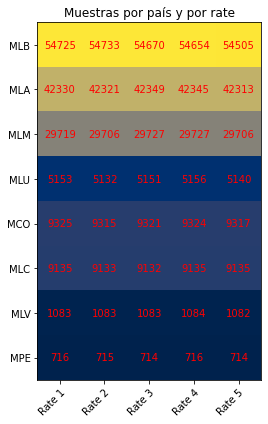

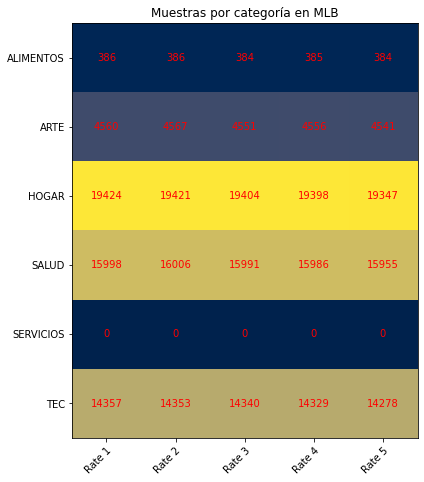

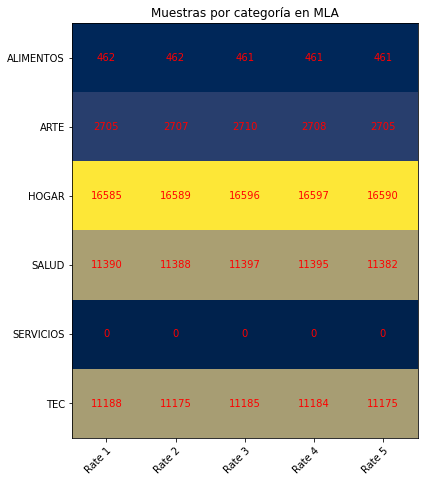

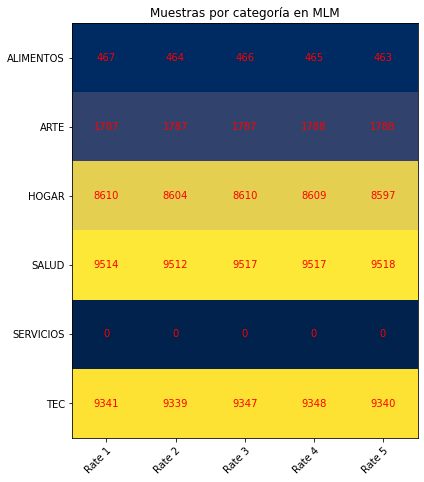

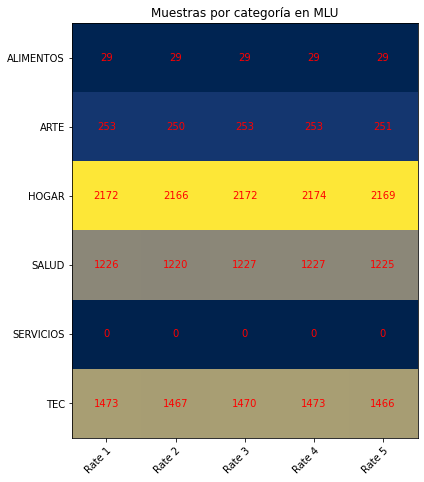

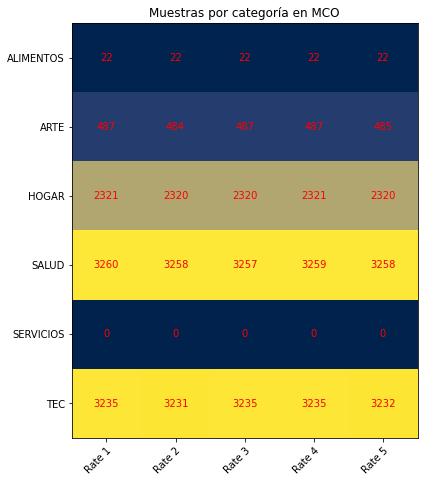

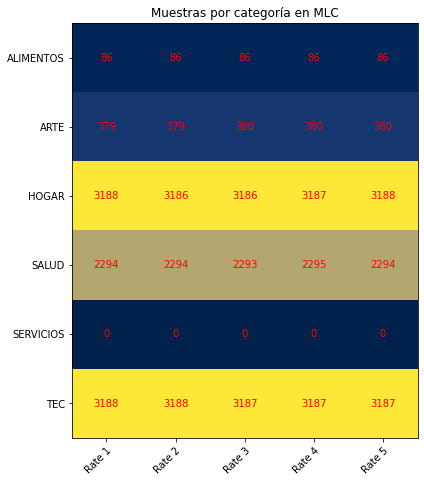

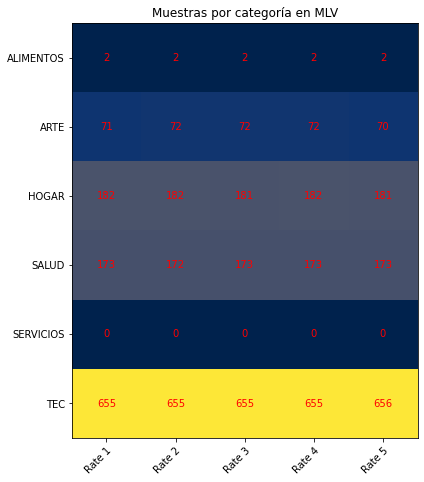

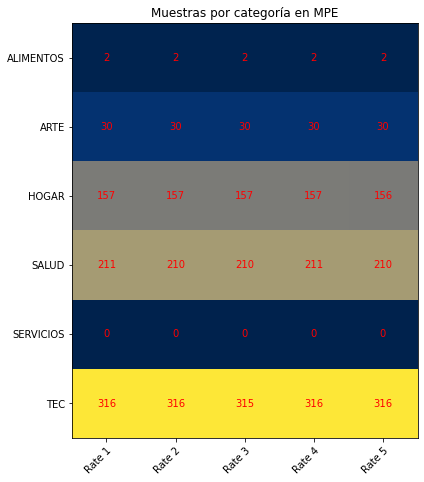

In [7]:
def plot_heatmap(matrix,countries,rates):

    fig, ax = plt.subplots(1,1,figsize=(len(countries),len(rates)+1))
    im = ax.imshow(matrix,cmap='cividis')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(rates)))
    ax.set_yticks(np.arange(len(countries)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(['Rate {}'.format(s) for s in rates])
    ax.set_yticklabels(countries)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(countries)):
        for j in range(len(rates)):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="red")

    ax.set_title("Muestras por país y por rate")
    fig.tight_layout()
    return fig, ax

df = pd.concat([df_esp,df_por],ignore_index=True)
countries = ['MLB','MLA','MLM','MLU','MCO','MLC','MLV','MPE']
rates = [1, 2, 3, 4, 5]
matrix = np.zeros((len(countries),len(rates)),dtype=np.int)
for i,country in enumerate(countries):
    for j,rate in enumerate(rates):
        mymask = (df['review_rate'] == rate) & (df['country'] == country)
        matrix[i,j] = len(df[mymask])

fig, ax = plot_heatmap(matrix,countries,rates)
fig.show()


def plot_heatmap2(matrix,yticks,xticks,title):

    fig, ax = plt.subplots(1,1,figsize=(len(yticks),len(xticks)*2))
    im = ax.imshow(matrix,cmap='cividis')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(xticks)))
    ax.set_yticks(np.arange(len(yticks)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(['Rate {}'.format(s) for s in xticks])
    ax.set_yticklabels(yticks)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(yticks)):
        for j in range(len(xticks)):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="red")

    ax.set_title(title)
    fig.tight_layout()
    return fig, ax

abbreviations = {'Hogar / Casa': 'HOGAR',
'Tecnología y electrónica / Tecnologia e electronica': 'TEC',
'Arte y entretenimiento / Arte e Entretenimiento': 'ARTE',
'Salud, ropa y cuidado personal / Saúde, roupas e cuidado pessoal': 'SALUD',
'Alimentos y Bebidas / Alimentos e Bebidas': 'ALIMENTOS',
'Servicios / Serviços': 'SERVICIOS'}

categories = sorted(list(abbreviations.keys()))
abbs = [abbreviations[cat] for cat in categories]

for country in countries:
    print(country)
    matrix = np.zeros((len(categories),len(rates)),dtype=np.int)
    for i,category in enumerate(categories):
        for j,rate in enumerate(rates):
            mymask = (df['review_rate'] == rate) & (df['category'] == category) & (df['country'] == country)
            matrix[i,j] = mymask.sum()

    fig, ax = plot_heatmap2(matrix,abbs,rates,title='Muestras por categoría en {}'.format(country))
    fig.show()

In [8]:
df_esp['review_rate'].value_counts()

4    97487
3    97477
1    97461
5    97407
2    97405
Name: review_rate, dtype: int64

In [26]:
def get_vocab(df,pattern):
    ds_text = df['review_title'] + ' ' + df['review_content']
    vocab = ds_text.str.findall(pattern).explode().value_counts()
    return vocab

non_ascii = 'áàâãäÁÀÂÃÄéèêëÉÈÊẼËíìîĩïÍÌÎĨÏóòôõöÓÒÔÕÖúùûũüÚÙÛŨÜñÑçÇ'
regex = r'[a-zA-Z{}]+|[{}]+|[{}]'.format(non_ascii,string.digits,re.escape(string.punctuation))
vocab_esp = get_vocab(df_esp,regex)

non_ascii = 'áàâãäÁÀÂÃÄéèêëÉÈÊẼËíìîĩïÍÌÎĨÏóòôõöÓÒÔÕÖúùûũüÚÙÛŨÜñÑçÇ'
regex = r'[a-zA-Z{}]+|[{}]+|[{}]'.format(non_ascii,string.digits,re.escape(string.punctuation))
vocab_por = get_vocab(df_por,regex)

In [27]:
vocab_por_lens = vocab_por[vocab_por < 10].to_frame().reset_index()
vocab_por_lens['len'] = vocab_por_lens['index'].str.len()
vocab_por_len = vocab_por_lens.sort_values(by=['len'],ascending=False)
vocab_por_len['index']

64093    Bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb...
40514    topppppppppppppppppppppppppppppppppppppppppppp...
42482    1000000000000000000000000000000000000000000000...
63371    recomendoooooooooooooooooooooooooooooooooooooo...
37674    Ótimoótimoótimoótimoótimoótimoótimoótimoótimoó...
                               ...                        
24209                                                    Z
556                                                      J
16157                                                    ã
40852                                                    Í
11099                                                    Ç
Name: index, Length: 87395, dtype: object

In [24]:
vocab_lens = vocab[vocab < 10].to_frame().reset_index()
vocab_lens['len'] = vocab_lens['index'].str.len()
vocab_len = vocab_lens.sort_values(by=['len'],ascending=False)
vocab_len['index']

115573    Buenaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...
71131     graciassssssssssssssssssssssssssssssssssssssss...
57578     aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...
85274     graciassssssssssssssssssssssssssssssssssssssss...
130622    1000000000000000000000000000000000000000000000...
                                ...                        
58613                                                     ü
116267                                                    Á
26103                                                     É
39441                                                     Ó
14640                                                     à
Name: index, Length: 150794, dtype: object

In [28]:
vocab_por_len.loc[:,['index']].to_csv('words_por.csv')

In [18]:
for i, (idx, token) in enumerate(vocab_len['index'].items()):
    print(idx, token)

e
70888 desprentan
65050 renovision
369 deliniador
8854 desvanezca
13657 dollarcity
65028 exprimiera
64966 microbrute
8826 cocaciones
8825 Promociona
64860 obtengodel
13784 eliminamos
37966 Insestable
64881 devoluvión
13789 debolverlo
13790 escribamos
13791 telamuyfea
64876 soñoliento
8797 escupidera
35710 inpresisos
84409 CANDELABRO
8795 liberarlas
64854 GRADUACIÓN
35715 sinfinitas
13807 encendidad
35709 duplicolor
13810 qedarmelos
84412 Traslucido
8794 filamentes
64841 intercalen
8792 poprqueria
64827 desflequeo
13823 arrempenti
37982 Teniéndolo
64821 hidrátense
64890 inductivas
84405 treslubros
64956 clickearlo
81201 hidràulica
64952 electricid
13725 ingresarse
64951 quedársela
84398 xreposeras
13733 exparcidos
64944 encadenada
8822 siliquinas
70926 tambiennlo
83426 pofesional
8817 portulacas
64932 recomfndar
64922 descartabl
70960 vestrellas
64918 cambienlos
37953 resultaran
81790 desensores
92794 expectativ
64908 cometierra
70936 hermoooosa
64904 planchaban
37954 ejecutadas
13766 

In [37]:
df_port = pd.read_csv('./reviews_port_not_cleaned_by_lang.csv')
print(df_port[df_port['Unnamed: 0'] == 'y']['Unnamed: 1'].tolist())

[673135, 536473, 515935, 605732, 727976, 729075, 672764, 672730, 548830, 544219, 728316, 760492, 741674, 499916, 513643, 513634, 545284, 753752, 626277, 514047, 710682, 713350, 526448, 529708, 683710, 744886, 543480, 727872, 703257, 726959, 588380, 735125, 677085, 720021, 576790, 558570, 632848, 677163, 587636, 513031, 720041, 548610, 744736, 556279, 676047, 558581, 538603, 703724, 604297, 648655, 675952, 544977, 544973, 544974, 623236, 555777, 717505, 541370, 600409, 550476, 558981, 513479, 745345, 756393, 587479, 674318, 528652, 515991, 550702, 558657, 723661, 492344, 589611, 513665, 513659, 677742, 633038, 737228, 679228, 513222, 694485, 676009, 590891, 629436, 743970, 712616, 529442, 512321, 588413, 588871, 588908, 546170, 722058, 535926, 754630, 507094, 505956, 611223, 549633, 521823, 645210, 702370, 754415, 637136, 734732, 549423, 553373, 634557, 626056, 548315, 740467, 506599, 592017, 618432, 675219, 518528, 636846, 523478, 547531, 757850, 547528, 655977, 550950, 532936, 548554,